# Predictiong biochemical activity against 2c9 with a small dataset

In this notebook we will try to use the more representative features of the Morgan fingerprint and the physicochemical descriptors given by Mordred library to fit a model with small dataset.


## Overview

- Load data
- Get fingerprint (in this case we simply load it from files)
- Get descriptors
    - Remove outliers and Normalise data
- Select data with mutual information score
- DNN
    - Hyperparameters tunning

## 1) Packages

In [1]:
%matplotlib inline
%load_ext tensorboard
!rm -rf ./logs/ 

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize #, minmax_scale it could also be tried.
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from rdkit import Chem
from mordred import Calculator, descriptors

plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
print(tf.__version__)

load_clean_data =  True # Otherwise it will load data with NaN

2.0.0


## 2) Loading data

In [2]:
PATH_DATA = "../datasets/CYP/"

shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [3]:
def col_to_array(df, col_name='p450-cyp2c9 Activity Outcome'):
    col = df[col_name]
    arr = col.to_numpy() # class wants to make reference to active or inactive
    arr = np.reshape(arr, [arr.shape[0],1])
    return np.squeeze(arr)

In [4]:
smi_col_shared = col_to_array(shared_data, 'CanonicalSMILES')
smi_col_only2c9 = col_to_array(testing_2c9_data, 'CanonicalSMILES')

## 3) Getting Mordred descriptors

We generate the descriptors using Mordred if ther are not in the features folder, otherwise the data is loaded from there.

There are two types of data we can load:

- Data without processing: this contains all the physicochemical descriptors that are generated with Mordred.
- Clean data: this data doesn't contains all the descriptors computed by Mordred. All the columns wich contain NaN, are remove to easily apply the feature selection.
    - This data has been processed as follows:
        - Convert all the str in the data frame to NaN.
        - Remove columns that contain NaN values.
            - Note that if we remove rows, we obtain an empty df (-> everything is removed)
        - Remove the all the columns with different headers between the shared and only 2c9 datasets.

In [5]:
def get_descriptors(smi_arr, activity_labels, clean_dataset=True, save_to_npy=True, filename='shared_set_features_mordred'):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in smi_arr]
    df_descriptors = calc.pandas(mols)
    df_descriptors = df_descriptors.insert(0, "p450-cyp2c9 Activity Outcome", activity_labels, True)
    if clean_dataset:
        df_descriptors = descriptors_shared.apply(pd.to_numeric, errors='coerce')
        df_descriptors = df_descriptors.dropna(axis=1)
    if save_to_npy:
        df_descriptors.to_csv(os.path.join("features", filename + ".npy"))
    return df_descriptors

In [6]:
if load_clean_data:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred_clean.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred_clean.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=True, filename='shared_set_features_mordred_clean')

    if os.path.exists(os.path.join("features", "only2c9_features_mordred_clean.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred_clean.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=True, filename='only2c9_features_mordred_clean')

else:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=False, filename='shared_set_features_mordred')

    if os.path.exists(os.path.join("features", "only2c9_features_mordred.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=False, filename='only2c9_features_mordred')

In [7]:
if load_clean_data: # To get data with the same descriptors
    lst_shared_clean=list(descriptors_shared.columns.values)
    lst_only2c9_clean=list(descriptors_only2c9.columns.values)
    common_elements=list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean)-set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean)-set(common_elements))
    
    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)

In [8]:
print(descriptors_shared.shape, descriptors_only2c9.shape)

(9420, 752) (2813, 752)


## 4) Get features (Morgan fingerprint)

In [9]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [10]:
if os.path.exists(os.path.join("features", "shared_set_features.npy")):
    features_shared = np.load(os.path.join("features", "shared_set_features.npy"))
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save(os.path.join("features", "shared_set_features.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_2c9_set_features.npy")):
    features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features.npy"))
else:
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set.sdf"))
    np.save(os.path.join("features", "only_2c9_set_features.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_3a4_set_features.npy")):
    features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features.npy"))
else:
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set.sdf.sdf"))
    np.save(os.path.join("features", "only_3a4_set_features.npy"), features_shared)

## 5) Feature selection

In this part we want to select the descriptors and the finferprint features that are very representative of the molecule activity.

In the following cell there are the percentage of values that are kept of the descriptors.
Since the fingerprint seems to have a low score in all its features (see plots below), a lower percentil was selected in order to avoid 'noise'.

In [11]:
# Percentage to be kept
percetile_descriptors = 60
percetile_fingerprint = 60 #40

In [12]:
def select_features_univar(X_train, Y_train, X_test, score_func=chi2, k_best=None, percentile = None):
    """score_func=chi2 (default), mutual_info_classif"""
    if not k_best == None:
        fs = SelectKBest(score_func=score_func, k=k_best)
    elif not percentile == None:
        fs = SelectPercentile(score_func=score_func, percentile=percentile)
    else:
        print("Introduce the number of best features to be kept (`k_best`) or the percentil.")
        return
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def plot_score(fs, print_scores=False):
    """plot the score for all the features"""
    if print_scores:
        for i in range(len(fs.scores_)):
            print('Feature %d: %f' % (i, fs.scores_[i]))
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()

### 5.1) Descriptors selection

In this part we want to select the descriptors that are representative of the molecule activity.
To do so, the the mutual information classification is used for the descriptor selection, since the [Pearson chi square's test does not apply to negative values](https://stackoverflow.com/questions/25792012/feature-selection-using-scikit-learn).

Possible solutions that could be explored to use the Pearson test are (see link above):
- Normalization of values 
- Shift of values to avoid negative values.

A practical consideration for this task is that the column `'p450-cyp2c9 Activity Outcome'` in the descriptors dataframe, has to be removed and introduced to the function as a label.



In [13]:
remove_outliers = True
normalize_descriptors = True

#### 5.1.1) Detection and remove of Outliers

Before selecting features, we will remove the examples that contain outliers using the Z score criteria.

$Z = \frac{X-\mu}{\sigma}$

Z-scores can quantify the unusualness of an observation when your data follow the normal distribution. Z-scores are the number of standard deviations above and below the mean that each value falls. For example, a Z-score of 2 indicates that an observation is two standard deviations above the average while a Z-score of -2 signifies it is two standard deviations below the mean. A Z-score of zero represents a value that equals the mean. [Source](https://statisticsbyjim.com/basics/outliers/)

In [14]:
def compute_z_score(df_original):
    df=df_original.copy()
    headers = []
    for col in df.columns:
        df[f'{col}_zscore'] = (df[col] - df[col].mean())/df[col].std(ddof=0)
        headers.append(col)
    return df, headers

def outliers_detection(df, threshold=3):
    df_scored, headers=compute_z_score(df)
    zscore_col = list(set(df_scored.columns) - set(headers)) # to only evaluate zscore columns
    for col in zscore_col:
        df_scored[f'{col}_outlier'] = (abs(df_scored[f'{col}'])> threshold).astype(int)
    return df_scored, zscore_col

def drop_outliers(df, threshold=3):
    df_outlier, zscore_col = outliers_detection(df, threshold=threshold)
    for col in zscore_col:
        index = df_outlier[ df_outlier[f'{col}_outlier'] == 1 ].index
        df_outlier.drop(index , inplace=True)
        df_outlier.drop(col , inplace=True,axis = 1)
        df_outlier.drop(f'{col}_outlier' , inplace=True, axis = 1)
    return df_outlier

"""
# RuntimeWarning: invalid value encountered in less
# This is separate from the ipykernel package so we can avoid doing imports until
def drop_outliers(df_original, threshold=3):
    df=df_original.copy()
    return df[(np.abs(stats.zscore(df)) < threshold).all(axis=1)]
    
df_2 = drop_outliers(descriptors_only2c9.astype('float64'),threshold=100)
"""

"\n# RuntimeWarning: invalid value encountered in less\n# This is separate from the ipykernel package so we can avoid doing imports until\ndef drop_outliers(df_original, threshold=3):\n    df=df_original.copy()\n    return df[(np.abs(stats.zscore(df)) < threshold).all(axis=1)]\n    \ndf_2 = drop_outliers(descriptors_only2c9.astype('float64'),threshold=100)\n"

Note that in this cell we remove the molecules which contain descriptors' outliers in the fingerprint dataset.

In [15]:
if remove_outliers:
    threshold = 3
    if not os.path.exists(os.path.join("features", "shared_set_features_mordred_clean_no_outliers.npy")):
        descriptors_shared = drop_outliers(descriptors_shared, threshold=threshold)
        descriptors_shared.to_csv(os.path.join("features", 'shared_set_features_mordred_clean_no_outliers.npy'))   
    descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred_clean_no_outliers.npy"))
    loc = list(descriptors_shared['Unnamed: 0'])
    features_shared = features_shared[loc,:]
    descriptors_shared = descriptors_shared.drop(['Unnamed: 0'], axis=1)
  
    if not os.path.exists(os.path.join("features", "only2c9_features_mordred_clean_no_outliers.npy")):
        descriptors_only2c9 = drop_outliers(descriptors_only2c9, threshold=threshold)
        descriptors_only2c9.to_csv(os.path.join("features", 'only2c9_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred_clean_no_outliers.npy"))
    loc = list(descriptors_only2c9['Unnamed: 0'])
    features_only_2c9 = features_only_2c9[loc,:]
    descriptors_only2c9 = descriptors_only2c9.drop(['Unnamed: 0'], axis=1)

In [16]:
descriptors_shared.shape, descriptors_only2c9.shape

((2372, 752), (846, 752))

In [17]:
if remove_outliers and not descriptors_only2c9.shape[1] == descriptors_shared.shape[1]:
    lst_shared_clean=list(descriptors_shared.columns.values)
    lst_only2c9_clean=list(descriptors_only2c9.columns.values)
    common_elements=list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean)-set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean)-set(common_elements))
    
    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)
    
    descriptors_shared.to_csv(os.path.join("features", 'shared_set_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9.to_csv(os.path.join("features", 'only2c9_features_mordred_clean_no_outliers.npy'))
    
    labels_2c9 = np.array(descriptors_shared['p450-cyp2c9 Activity Outcome'])
    labels_testing_2c9 = np.array(descriptors_only2c9['p450-cyp2c9 Activity Outcome'])

In [18]:
descriptors_shared.shape, descriptors_only2c9.shape

((2372, 752), (846, 752))

In [22]:
#descriptors_shared.columns.values

#### 5.1.2) Normalisation

Now we are going to normalise each feature of the dataset to values between [0,1]

In [23]:
norm_descriptors_shared = pd.DataFrame(normalize(descriptors_shared, norm='max', axis=0))
norm_descriptors_only2c9 = pd.DataFrame(normalize(descriptors_only2c9, norm='max', axis=0))

In [24]:
labels_2c9 = np.array(norm_descriptors_shared[0])
labels_testing_2c9 = np.array(norm_descriptors_only2c9[0])

#### 5.1.2) Selection of descriptors

Finally we can now select the more relevants descriptors using Mutual information criteria!

In [25]:
norm_descriptors_shared = norm_descriptors_shared.drop([0], axis=1)
norm_descriptors_only2c9 = norm_descriptors_only2c9.drop([0], axis=1)

In [26]:
norm_shared_descriptors_fs, norm_only2c9_descriptors_fs, norm_fs = select_features_univar(norm_descriptors_shared, labels_2c9, norm_descriptors_only2c9, score_func=mutual_info_classif, percentile = percetile_descriptors)

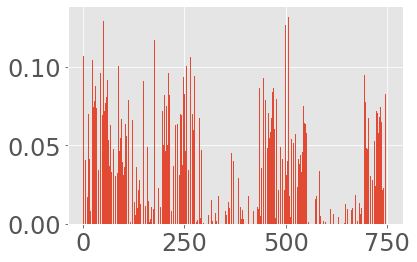

In [27]:
plot_score(norm_fs)

In [28]:
print(norm_shared_descriptors_fs.shape, norm_only2c9_descriptors_fs.shape)

(2372, 450) (846, 450)


### 5.2) Fingerprint features selection

In this part we want to select the fingerprint features that are very representative of the molecule activity.
To do so, the the mutual information classification is used for the descriptor selection, for coherence with the descriptors.

However, in this case it is not mandatory to use the mutual information classification, therefore, we could also use the chi2 test.

Moreover, as the fingerprint are "boolean descriptors", we could also implement a variance threshold, as it has been previously done in other studies (Joan).

In [29]:
shared_features_fs, only2c9_features_fs, fs_morgan = select_features_univar(features_shared, labels_2c9, features_only_2c9, score_func=mutual_info_classif, percentile = percetile_fingerprint)

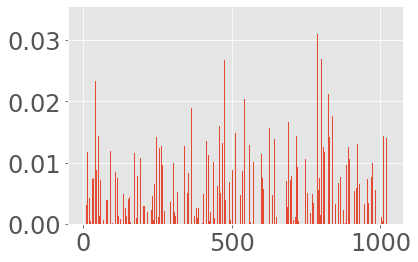

In [30]:
plot_score(fs_morgan)

In [31]:
print(shared_features_fs.shape, only2c9_features_fs.shape)

(2372, 614) (846, 614)


## 6) Preparing the trainig, validatio and test sets

### 6.1) Joining selected descriptors and fingerprints



Now we have to join both data into a df that will be used to train and evaluate a NN.

In [32]:
concatenated_shared = np.concatenate([norm_shared_descriptors_fs, shared_features_fs], axis=1)
concatenated_only2c9 = np.concatenate([norm_only2c9_descriptors_fs, only2c9_features_fs], axis=1)

In [33]:
concatenated_shared.shape[1]==concatenated_only2c9.shape[1]

True

### 6.2) Splitting the data

We will split the data and reduce the training set to:

- 375 examples for the training set from the shared dataset (`concatenated_shared`)
- 125 examples for the validation set from the shared dataset (`concatenated_shared`)
- 125 examples for the test set from the only2c9 dataset (`concatenated_only2c9`)

In [41]:
def split_test_data(full_testset, labels_full_testset, testset_size, seed=1):
    np.random.seed(seed)
    m_testset = full_testset.shape[0] # number of examples in the full test set
    permutation_testset = list(np.random.permutation(m_testset))
    shuffled_test_data = full_testset[permutation_testset,:]
    shuffled_labels_test = labels_full_testset[permutation_testset]
    mini_test = shuffled_test_data[:testset_size,:]
    mini_labels_test = shuffled_labels_test[:testset_size].reshape(testset_size,1)
    return mini_test, mini_labels_test

In [42]:
dataset_size = 500                  # training + validation sets
trainset_size = int(0.75 * dataset_size)
testset_size = int(0.25 * dataset_size)  # To have the same #examples in the test and validation set (Assuming that the mini_dataset will be split 75% train/25%val.)

mini_testing_2c9_data, mini_labels_testing_2c9_data = split_test_data(concatenated_only2c9, labels_testing_2c9, testset_size)
print(mini_testing_2c9_data.shape, mini_labels_testing_2c9_data.shape)

(125, 1064) (125, 1)


(375, 1064) (125, 1064) (375,) (125,)


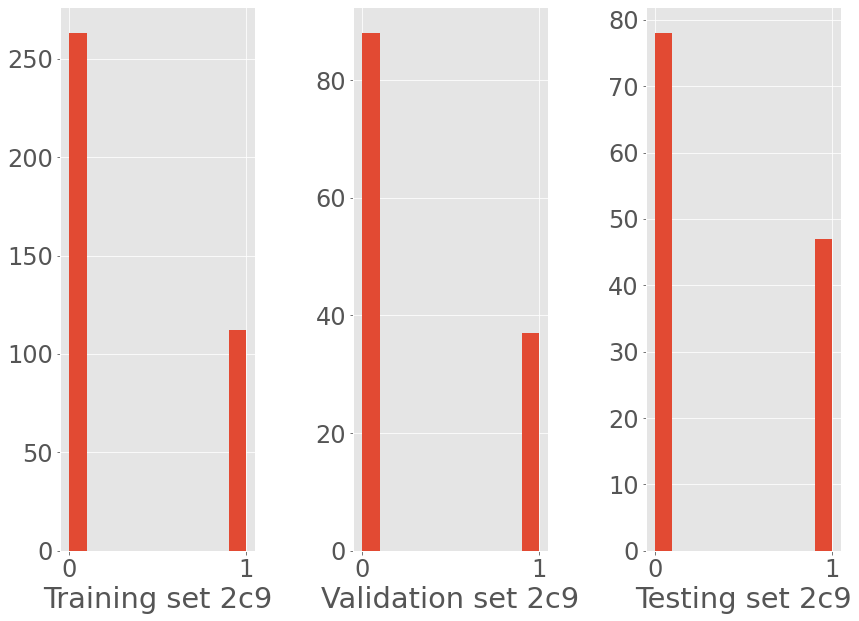

In [43]:
train_data, val_data, train_labels, val_labels = train_test_split(concatenated_shared, labels_2c9, train_size=trainset_size, test_size=testset_size, stratify=labels_2c9, random_state=2)
print(train_data.shape, val_data.shape, train_labels.shape, val_labels.shape)
fig, ax = plt.subplots(1, 3, figsize=(14,10))
ax[0].hist(train_labels)
ax[0].set_xlabel("Training set 2c9")
ax[1].hist(val_labels)
ax[1].set_xlabel("Validation set 2c9")
ax[2].hist(mini_labels_testing_2c9_data)
ax[2].set_xlabel("Testing set 2c9")
plt.subplots_adjust(wspace=0.5)

In [36]:
train_data = np.asarray(train_data).astype(np.float32)
val_data = np.asarray(val_data).astype(np.float32)
mini_testing_2c9_data = np.asarray(mini_testing_2c9_data).astype(np.float32)

Since we have an unbalanced dataset, we will attribute to each class a weight.
In this way we simulate having the same number of active and inactive cases.

In [37]:
class_weights = compute_class_weight('balanced',np.unique(train_labels), train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0

In [38]:
class_weight

{0: 0.7129277566539924, 1: 1.6741071428571428}

## 7) Neural network

In [57]:
def generate_model(layers_dim, lr, dropout, optimizer, L2):
    """layers_dim -- [n_input, n_hid_1, ..., n_output=1]"""
    hidden_layers = []
    for i in range(1,len(layers_dim)-1): hidden_layers.extend([tf.keras.layers.Dropout(dropout)] + [tf.keras.layers.Dense(layers_dim[i], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2))])
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(layers_dim[0], activation='relu', input_shape=(layers_dim[0],))] +
        hidden_layers + 
        [tf.keras.layers.Dense(layers_dim[-1], activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 
    return model

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    plt.show()

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [accuracy, mcc]#mcc


"""
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.80):
          print("\n Reached 80% accuracy on training set so cancelling training!")
          self.model.stop_training = True
        if(logs.get('val_accuracy')>0.80):
          print("\n Reached 70% accuracy on validation set so cancelling training!")
          self.model.stop_training = True
"""      

'\nclass myCallback(tf.keras.callbacks.Callback):\n    def on_epoch_end(self, epoch, logs={}):\n        if(logs.get(\'accuracy\')>0.80):\n          print("\n Reached 80% accuracy on training set so cancelling training!")\n          self.model.stop_training = True\n        if(logs.get(\'val_accuracy\')>0.80):\n          print("\n Reached 70% accuracy on validation set so cancelling training!")\n          self.model.stop_training = True\n'

In [56]:
from io import BytesIO

logdir="logs/fit/morgan_mordred_Mix_norm_6060_feature_selection/"
classes=['Inactive', 'Active']

file_writer = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    val_pred = model_small_dataset.predict_classes(val_data)
 
    con_mat = tf.math.confusion_matrix(labels=val_labels, predictions=val_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
    con_mat_df = pd.DataFrame(con_mat_norm,
                             index = classes, 
                             columns = classes)
 
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    buf = BytesIO()
    plt.savefig(buf, format='png')
 
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
 
    image = tf.expand_dims(image, 0)
  
    # Log the confusion matrix as an image summary.
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)
  
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
 
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [111]:
import datetime

layers_dim = [train_data.shape[1], 70,70,70, 1]
lr = 0.01#0.001
dropout = 0.5
optimizer = 'Adam'#'adam'
L2 = 0.01#0.001

#callbacks = myCallback()

os.makedirs("logs/fit/morgan_mordred_Mix_norm_6060_feature_selection", exist_ok=True)
log_dir = "logs/fit/morgan_mordred_Mix_norm_6060_feature_selection/" + f'nl_{layers_dim}_lr_{lr}_drop_{dropout}_opt_{optimizer}_L2_{L2}' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
hist_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_small_dataset =generate_model(layers_dim, lr, dropout, optimizer, L2)
#model_small_dataset.summary()


history = model_small_dataset.fit(
      train_data, train_labels,
      epochs=10,
      verbose=2,
      #validation_data = (mini_testing_2c9_data, mini_labels_testing_2c9_data)
      validation_data = (val_data, val_labels),
      callbacks=[hist_callback, cm_callback],
      class_weight=class_weight
      )

Train on 375 samples, validate on 125 samples
Epoch 1/10
375/375 - 10s - loss: 3.2170 - accuracy: 0.4613 - precision_10: 0.2897 - recall_10: 0.5536 - val_loss: 2.9188 - val_accuracy: 0.7040 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/10
375/375 - 2s - loss: 2.7539 - accuracy: 0.4667 - precision_10: 0.2982 - recall_10: 0.5804 - val_loss: 2.5253 - val_accuracy: 0.7200 - val_precision_10: 0.6667 - val_recall_10: 0.1081
Epoch 3/10
375/375 - 2s - loss: 2.4118 - accuracy: 0.5040 - precision_10: 0.3150 - recall_10: 0.5625 - val_loss: 2.2425 - val_accuracy: 0.7040 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 4/10
375/375 - 2s - loss: 2.1471 - accuracy: 0.4293 - precision_10: 0.2976 - recall_10: 0.6696 - val_loss: 2.0110 - val_accuracy: 0.6160 - val_precision_10: 0.4068 - val_recall_10: 0.6486
Epoch 5/10
375/375 - 2s - loss: 1.9319 - accuracy: 0.4400 - precision_10: 0.3086 - recall_10: 0.7054 - val_loss: 1.8349 - val_accuracy: 0.6400 - val_precision_10

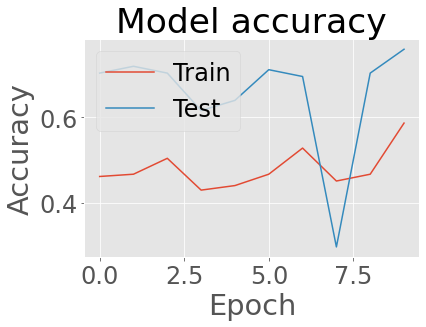

In [112]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

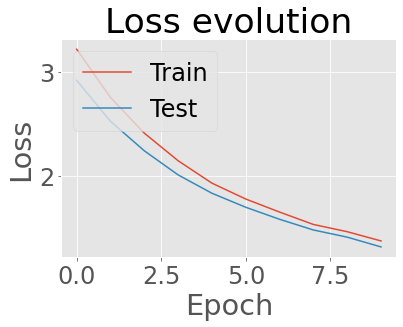

In [113]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

125/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

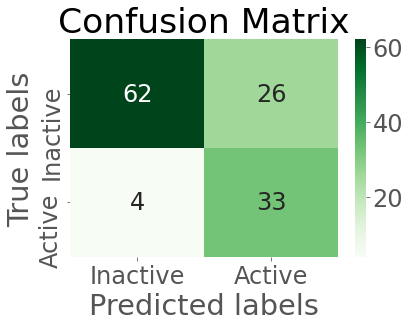

In [114]:
results = model_small_dataset.evaluate(val_data, val_labels)
predictions = model_small_dataset.predict(val_data)
print_metrics(predictions, val_labels)
plot_confusion(predictions, val_labels)

125/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

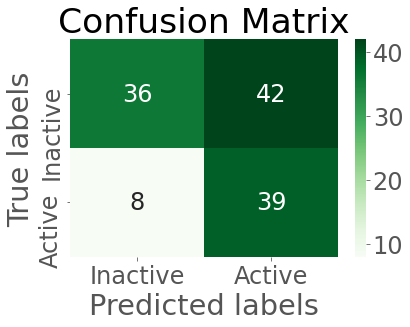

In [115]:
results = model_small_dataset.evaluate(mini_testing_2c9_data, mini_labels_testing_2c9_data)
predictions = model_small_dataset.predict(mini_testing_2c9_data)
print_metrics(predictions, mini_labels_testing_2c9_data)
plot_confusion(predictions, mini_labels_testing_2c9_data)

In [53]:
%tensorboard --logdir logs/fit/morgan_mordred_Mix_norm_6060_feature_selection

### 7.2.) Cross Validation

Based on [Manual k-Fold Cross Validation](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/).

This methodology provides a robust estimation of the performance of a model on unseen data. It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset.

In the example below we use the handy StratifiedKFold class from the scikit-learn Python machine learning library to split up the training dataset into 10 folds. The folds are stratified, meaning that the algorithm attempts to balance the number of instances of each class in each fold.


In [59]:
def run_cross_validation(layers_dim, lr, dropout, optimizer, L2, train_val_data, train_val_labels, test_data, test_labels, folds=10, seed=1):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    MCCs_train, MCCs_val, MCCs_test = [],[],[]
    accs_train, accs_val, accs_test = [],[],[]
    actives_train, actives_val, actives_test = [],[],[]
    best_model = None
    best_model_MCC = -2
    best_model_ind = 0
    testset_size = int(train_val_data.shape[0]/folds)
    
    if not testset_size == test_data.shape[0]:
        test_data, test_labels = split_test_data(test_data, test_labels, testset_size, seed=seed)
    
    for i, (train_index, val_index) in enumerate(skf.split(train_val_data, train_val_labels)):
        train_data, val_data = train_val_data[train_index], train_val_data[val_index]
        train_labels, val_labels = train_val_labels[train_index], train_val_labels[val_index]
        actives_train.append(sum(train_labels))
        actives_val.append(sum(val_labels))
        actives_test.append(sum(test_labels))
        print(f"Calculating with fold {i}")
        
        model = generate_model(layers_dim, lr, dropout, optimizer, L2)
        history = model.fit(train_data, train_labels, epochs=10, verbose=2, validation_data = (val_data, val_labels), class_weight=class_weight)
      
        pred_train = model.predict(train_data)
        train_acc, train_mcc = print_metrics(pred_train, train_labels)

        pred_val = model.predict(val_data)
        print(f"---> Validation set fold {i}")
        val_acc, val_mcc = print_metrics(pred_val, val_labels)
        plot_confusion(pred_val, val_labels)
        
        predictions = model.predict(test_data)
        print(f"---> Test set fold {i}")
        test_acc, test_mcc = print_metrics(predictions, test_labels)
        plot_confusion(predictions, test_labels)
        
        if test_mcc > best_model_MCC:
            best_model = model
            best_model_MCC = test_mcc
            best_model_ind = i
        MCCs_train.append(train_mcc)
        MCCs_val.append(val_mcc)
        MCCs_test.append(test_mcc)
        accs_train.append(train_acc)
        accs_val.append(val_acc)
        accs_test.append(test_acc)
    print(f"Best model was obtained from fold {best_model_ind} with MCC {best_model_MCC}")
    for i, (train_index, test_index) in enumerate(skf.split(features, labels)):
        print(f"Calculating with fold {i}")
        train_data, val_data = train_val_data[train_index], train_val_data[val_index]
        train_labels, val_labels = train_val_labels[train_index], train_val_labels[val_index]
        
        pred_val = best_model.predict(val_data)
        print(f"---> Validation set fold {i}")
        print_metrics(pred_val, val_labels)
        plot_confusion(pred_val, val_labels)
        
        predictions = best_model.predict(test_data)
        print(f"---> Test set fold {i}")
        print_metrics(predictions, test_labels)
        plot_confusion(predictions, test_labels)
    return MCCs_train, MCCs_val, MCCs_test, accs_train, accs_val, accs_test, actives_train, actives_val, actives_test, best_model

def plot_results_CV(MCCs_train, MCCs_val, MCCs_test, accs_train, accs_val, accs_test, actives_train, actives_val, actives_test):
    fig, ax = plt.subplots(1,3, figsize=(16,8))
    y_min = -0.1+np.nanmin([np.nanmin(accs_train), np.nanmin(accs_test), np.nanmin(MCCs_train), np.nanmin(MCCs_test)])
    y_max = 0.1+np.nanmax([np.nanmax(accs_train), np.nanmax(accs_test), np.nanmax(MCCs_train), np.nanmax(MCCs_test)])
    ax[0].boxplot([accs_train, accs_val, accs_test], labels=["Training", "Validation" , "Testing"])
    ax[1].boxplot([MCCs_train, MCCs_val, MCCs_test], labels=["Training", "Validation", "Testing"])
    ax[2].boxplot([actives_train, actives_val, actives_test], labels=["Training", "Validation", "Testing"])
    ax[0].set_ylim(top=y_max, bottom=y_min)
    ax[1].set_ylim(top=y_max, bottom=y_min)
    ax[0].set_ylabel("Accuracy")
    ax[1].set_ylabel("MCC")
    ax[2].set_ylabel("Actives proportion")

In [54]:
train_val_data = np.concatenate((train_data, val_data), axis=0)
train_val_labels = np.concatenate((train_labels, val_labels), axis=0)

In [55]:
train_val_data.shape, train_val_labels.shape

((500, 1064), (500,))

Calculating with fold 0
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 6s - loss: 3.1775 - accuracy: 0.4689 - precision_10: 0.3030 - recall_10: 0.5926 - val_loss: 2.8106 - val_accuracy: 0.7200 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/10
450/450 - 1s - loss: 2.6510 - accuracy: 0.5511 - precision_10: 0.3264 - recall_10: 0.4667 - val_loss: 2.3845 - val_accuracy: 0.2800 - val_precision_10: 0.2800 - val_recall_10: 1.0000
Epoch 3/10
450/450 - 1s - loss: 2.2970 - accuracy: 0.4444 - precision_10: 0.3051 - recall_10: 0.6667 - val_loss: 2.0811 - val_accuracy: 0.7400 - val_precision_10: 0.5333 - val_recall_10: 0.5714
Epoch 4/10
450/450 - 1s - loss: 2.0194 - accuracy: 0.5289 - precision_10: 0.3376 - recall_10: 0.5926 - val_loss: 1.8750 - val_accuracy: 0.6600 - val_precision_10: 0.2857 - val_recall_10: 0.1429
Epoch 5/10
450/450 - 1s - loss: 1.8198 - accuracy: 0.4756 - precision_10: 0.3203 - recall_10: 0.6667 - val_loss: 1.7108 - val_accuracy: 0.6800 - va

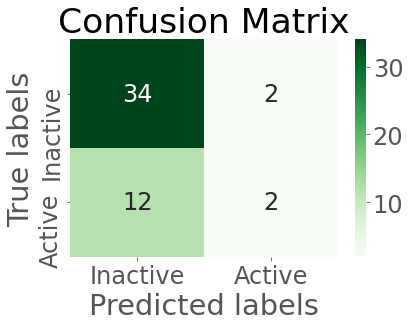

---> Test set fold 0
NER: 0.494, Sensitivity or recall: 0.071, Specificity: 0.917, Precision: 0.250, Correctly calssified: 0.680, MCC: -0.020


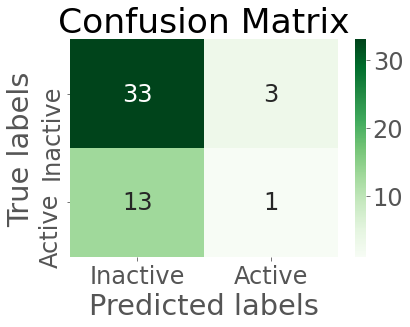

Calculating with fold 1
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 3.1960 - accuracy: 0.5200 - precision_11: 0.3010 - recall_11: 0.4627 - val_loss: 2.8341 - val_accuracy: 0.7000 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00
Epoch 2/10
450/450 - 1s - loss: 2.6834 - accuracy: 0.5267 - precision_11: 0.3260 - recall_11: 0.5522 - val_loss: 2.3996 - val_accuracy: 0.8000 - val_precision_11: 0.7778 - val_recall_11: 0.4667
Epoch 3/10
450/450 - 1s - loss: 2.3221 - accuracy: 0.5467 - precision_11: 0.3214 - recall_11: 0.4701 - val_loss: 2.1399 - val_accuracy: 0.3400 - val_precision_11: 0.3125 - val_recall_11: 1.0000
Epoch 4/10
450/450 - 1s - loss: 2.0619 - accuracy: 0.4911 - precision_11: 0.3333 - recall_11: 0.7090 - val_loss: 1.9341 - val_accuracy: 0.7800 - val_precision_11: 0.8333 - val_recall_11: 0.3333
Epoch 5/10
450/450 - 1s - loss: 1.8831 - accuracy: 0.5733 - precision_11: 0.3294 - recall_11: 0.4179 - val_loss: 1.7837 - val_accuracy: 0.5800 - va

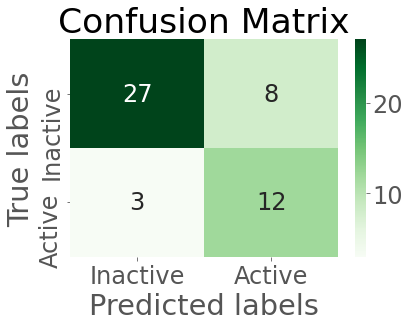

---> Test set fold 1
NER: 0.667, Sensitivity or recall: 1.000, Specificity: 0.333, Precision: 0.368, Correctly calssified: 0.520, MCC: 0.350


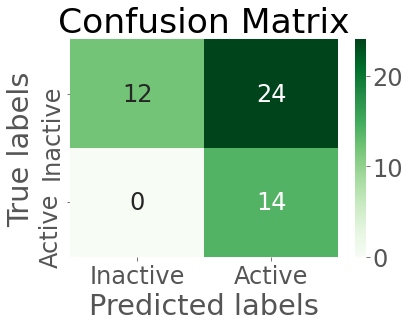

Calculating with fold 2
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 3.2005 - accuracy: 0.5222 - precision_12: 0.3151 - recall_12: 0.5149 - val_loss: 2.8447 - val_accuracy: 0.3000 - val_precision_12: 0.3000 - val_recall_12: 1.0000
Epoch 2/10
450/450 - 1s - loss: 2.6764 - accuracy: 0.4689 - precision_12: 0.3105 - recall_12: 0.6418 - val_loss: 2.4119 - val_accuracy: 0.7000 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 3/10
450/450 - 1s - loss: 2.2746 - accuracy: 0.5844 - precision_12: 0.3568 - recall_12: 0.4925 - val_loss: 2.1029 - val_accuracy: 0.7800 - val_precision_12: 1.0000 - val_recall_12: 0.2667
Epoch 4/10
450/450 - 1s - loss: 2.0088 - accuracy: 0.5422 - precision_12: 0.3286 - recall_12: 0.5149 - val_loss: 1.8887 - val_accuracy: 0.7000 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 5/10
450/450 - 1s - loss: 1.8236 - accuracy: 0.5444 - precision_12: 0.3476 - recall_12: 0.6045 - val_loss: 1.7209 - val_accuracy: 0.7

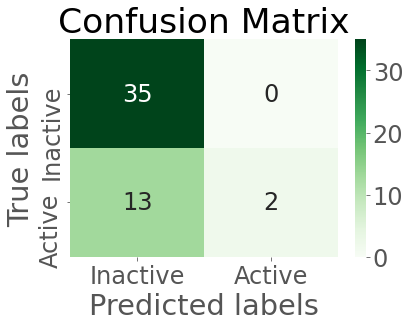

---> Test set fold 2
NER: 0.480, Sensitivity or recall: 0.071, Specificity: 0.889, Precision: 0.200, Correctly calssified: 0.660, MCC: -0.059


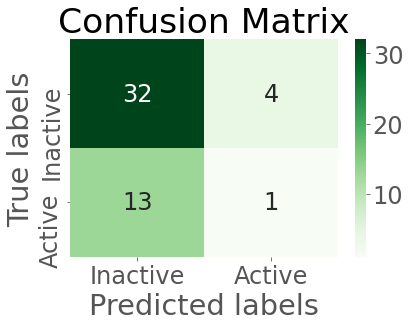

Calculating with fold 3
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 3.1234 - accuracy: 0.4511 - precision_13: 0.3148 - recall_13: 0.7164 - val_loss: 2.7827 - val_accuracy: 0.7000 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00
Epoch 2/10
450/450 - 1s - loss: 2.6407 - accuracy: 0.5689 - precision_13: 0.3295 - recall_13: 0.4328 - val_loss: 2.3646 - val_accuracy: 0.3200 - val_precision_13: 0.3061 - val_recall_13: 1.0000
Epoch 3/10
450/450 - 1s - loss: 2.2349 - accuracy: 0.5067 - precision_13: 0.3240 - recall_13: 0.6045 - val_loss: 2.0703 - val_accuracy: 0.6000 - val_precision_13: 0.4000 - val_recall_13: 0.6667
Epoch 4/10
450/450 - 1s - loss: 1.9808 - accuracy: 0.5622 - precision_13: 0.3521 - recall_13: 0.5597 - val_loss: 1.8630 - val_accuracy: 0.7200 - val_precision_13: 1.0000 - val_recall_13: 0.0667
Epoch 5/10
450/450 - 1s - loss: 1.8010 - accuracy: 0.5333 - precision_13: 0.3571 - recall_13: 0.7090 - val_loss: 1.7041 - val_accuracy: 0.7000 - va

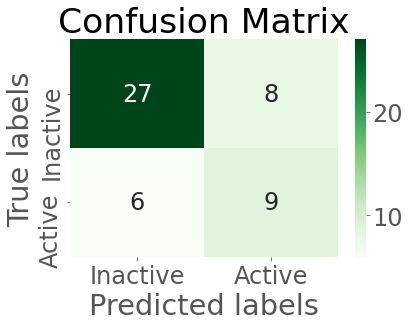

---> Test set fold 3
NER: 0.569, Sensitivity or recall: 0.500, Specificity: 0.639, Precision: 0.350, Correctly calssified: 0.600, MCC: 0.127


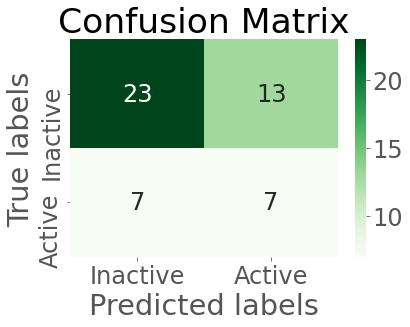

Calculating with fold 4
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 3.1971 - accuracy: 0.5778 - precision_14: 0.3391 - recall_14: 0.4403 - val_loss: 2.8683 - val_accuracy: 0.3000 - val_precision_14: 0.3000 - val_recall_14: 1.0000
Epoch 2/10
450/450 - 1s - loss: 2.7036 - accuracy: 0.5578 - precision_14: 0.3568 - recall_14: 0.6045 - val_loss: 2.4665 - val_accuracy: 0.3000 - val_precision_14: 0.3000 - val_recall_14: 1.0000
Epoch 3/10
450/450 - 1s - loss: 2.4182 - accuracy: 0.4667 - precision_14: 0.2977 - recall_14: 0.5821 - val_loss: 2.1944 - val_accuracy: 0.3000 - val_precision_14: 0.3000 - val_recall_14: 1.0000
Epoch 4/10
450/450 - 1s - loss: 2.1412 - accuracy: 0.4689 - precision_14: 0.2874 - recall_14: 0.5299 - val_loss: 2.0057 - val_accuracy: 0.3000 - val_precision_14: 0.3000 - val_recall_14: 1.0000
Epoch 5/10
450/450 - 1s - loss: 1.9678 - accuracy: 0.4467 - precision_14: 0.3127 - recall_14: 0.7164 - val_loss: 1.8601 - val_accuracy: 0.8200 - val_precis

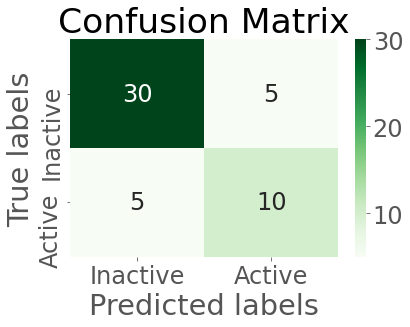

---> Test set fold 4
NER: 0.607, Sensitivity or recall: 0.714, Specificity: 0.500, Precision: 0.357, Correctly calssified: 0.560, MCC: 0.194


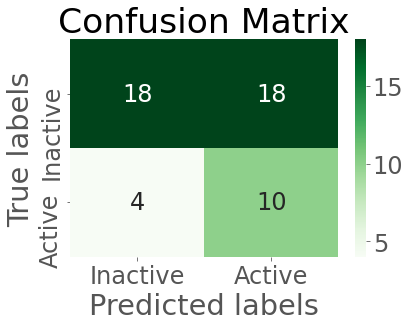

Calculating with fold 5
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 6s - loss: 3.1638 - accuracy: 0.5511 - precision_15: 0.3191 - recall_15: 0.4478 - val_loss: 2.8719 - val_accuracy: 0.3000 - val_precision_15: 0.3000 - val_recall_15: 1.0000
Epoch 2/10
450/450 - 1s - loss: 2.7265 - accuracy: 0.4467 - precision_15: 0.2691 - recall_15: 0.5000 - val_loss: 2.4243 - val_accuracy: 0.5800 - val_precision_15: 0.3500 - val_recall_15: 0.4667
Epoch 3/10
450/450 - 1s - loss: 2.3186 - accuracy: 0.5267 - precision_15: 0.3110 - recall_15: 0.4851 - val_loss: 2.1469 - val_accuracy: 0.3400 - val_precision_15: 0.3125 - val_recall_15: 1.0000
Epoch 4/10
450/450 - 1s - loss: 2.0834 - accuracy: 0.4356 - precision_15: 0.2945 - recall_15: 0.6418 - val_loss: 1.9452 - val_accuracy: 0.7400 - val_precision_15: 0.5625 - val_recall_15: 0.6000
Epoch 5/10
450/450 - 1s - loss: 1.8811 - accuracy: 0.4978 - precision_15: 0.3217 - recall_15: 0.6194 - val_loss: 1.7991 - val_accuracy: 0.5000 - val_precis

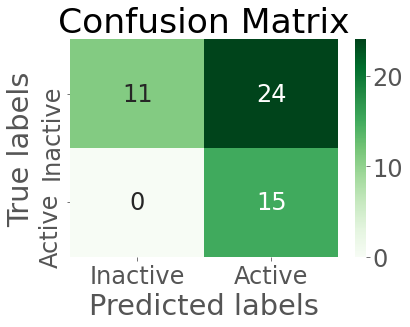

---> Test set fold 5
NER: 0.528, Sensitivity or recall: 1.000, Specificity: 0.056, Precision: 0.292, Correctly calssified: 0.320, MCC: 0.127


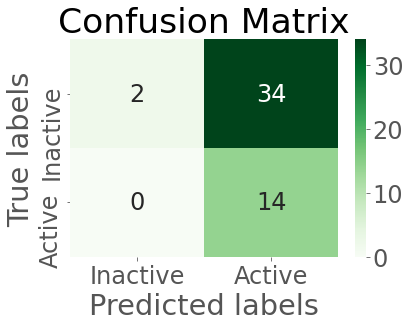

Calculating with fold 6
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 3.1873 - accuracy: 0.5267 - precision_16: 0.3333 - recall_16: 0.5896 - val_loss: 2.8246 - val_accuracy: 0.5400 - val_precision_16: 0.3462 - val_recall_16: 0.6000
Epoch 2/10
450/450 - 1s - loss: 2.6767 - accuracy: 0.5622 - precision_16: 0.3385 - recall_16: 0.4925 - val_loss: 2.4087 - val_accuracy: 0.3000 - val_precision_16: 0.3000 - val_recall_16: 1.0000
Epoch 3/10
450/450 - 1s - loss: 2.2679 - accuracy: 0.4444 - precision_16: 0.3141 - recall_16: 0.7313 - val_loss: 2.1035 - val_accuracy: 0.3000 - val_precision_16: 0.3000 - val_recall_16: 1.0000
Epoch 4/10
450/450 - 1s - loss: 2.0237 - accuracy: 0.4733 - precision_16: 0.3193 - recall_16: 0.6791 - val_loss: 1.8959 - val_accuracy: 0.3000 - val_precision_16: 0.3000 - val_recall_16: 1.0000
Epoch 5/10
450/450 - 1s - loss: 1.8326 - accuracy: 0.4333 - precision_16: 0.3215 - recall_16: 0.8134 - val_loss: 1.7678 - val_accuracy: 0.7000 - val_precis

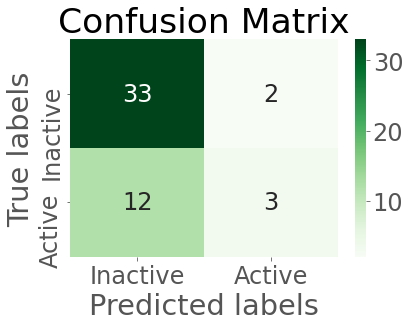

---> Test set fold 6
NER: 0.510, Sensitivity or recall: 0.214, Specificity: 0.806, Precision: 0.300, Correctly calssified: 0.640, MCC: 0.022


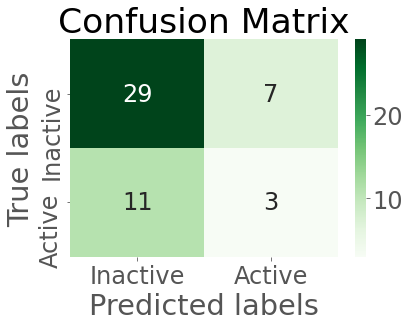

Calculating with fold 7
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 4s - loss: 3.2210 - accuracy: 0.4822 - precision_17: 0.2719 - recall_17: 0.4403 - val_loss: 2.8337 - val_accuracy: 0.3400 - val_precision_17: 0.3125 - val_recall_17: 1.0000
Epoch 2/10
450/450 - 1s - loss: 2.6570 - accuracy: 0.5378 - precision_17: 0.3363 - recall_17: 0.5672 - val_loss: 2.4116 - val_accuracy: 0.3000 - val_precision_17: 0.3000 - val_recall_17: 1.0000
Epoch 3/10
450/450 - 1s - loss: 2.2984 - accuracy: 0.5333 - precision_17: 0.3288 - recall_17: 0.5448 - val_loss: 2.1085 - val_accuracy: 0.6000 - val_precision_17: 0.4000 - val_recall_17: 0.6667
Epoch 4/10
450/450 - 1s - loss: 2.0395 - accuracy: 0.5267 - precision_17: 0.3163 - recall_17: 0.5075 - val_loss: 1.8994 - val_accuracy: 0.6400 - val_precision_17: 0.2857 - val_recall_17: 0.1333
Epoch 5/10
450/450 - 1s - loss: 1.8366 - accuracy: 0.5533 - precision_17: 0.3128 - recall_17: 0.4179 - val_loss: 1.7413 - val_accuracy: 0.3600 - val_precis

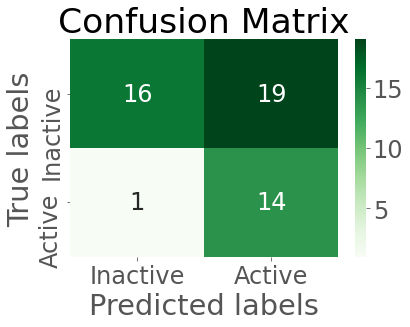

---> Test set fold 7
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.333, Correctly calssified: 0.440, MCC: 0.272


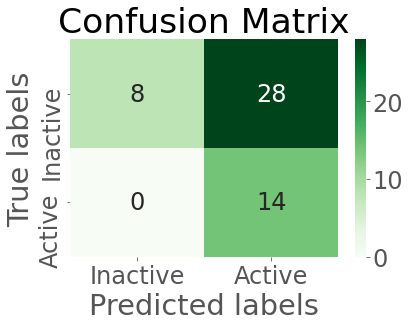

Calculating with fold 8
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 7s - loss: 3.1507 - accuracy: 0.4689 - precision_18: 0.3267 - recall_18: 0.7388 - val_loss: 2.7944 - val_accuracy: 0.3000 - val_precision_18: 0.3000 - val_recall_18: 1.0000
Epoch 2/10
450/450 - 1s - loss: 2.6479 - accuracy: 0.4933 - precision_18: 0.3074 - recall_18: 0.5597 - val_loss: 2.3585 - val_accuracy: 0.3000 - val_precision_18: 0.3000 - val_recall_18: 1.0000
Epoch 3/10
450/450 - 1s - loss: 2.2498 - accuracy: 0.4889 - precision_18: 0.2895 - recall_18: 0.4925 - val_loss: 2.0605 - val_accuracy: 0.3200 - val_precision_18: 0.3061 - val_recall_18: 1.0000
Epoch 4/10
450/450 - 1s - loss: 1.9806 - accuracy: 0.5444 - precision_18: 0.3122 - recall_18: 0.4403 - val_loss: 1.8510 - val_accuracy: 0.6000 - val_precision_18: 0.4242 - val_recall_18: 0.9333
Epoch 5/10
450/450 - 1s - loss: 1.7961 - accuracy: 0.5200 - precision_18: 0.3202 - recall_18: 0.5448 - val_loss: 1.6845 - val_accuracy: 0.5000 - val_precis

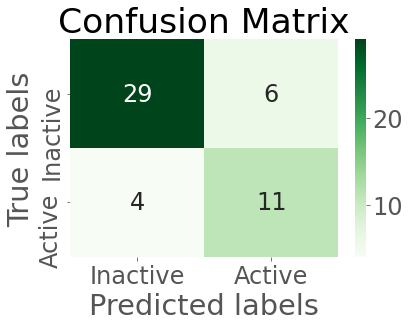

---> Test set fold 8
NER: 0.476, Sensitivity or recall: 0.286, Specificity: 0.667, Precision: 0.250, Correctly calssified: 0.560, MCC: -0.046


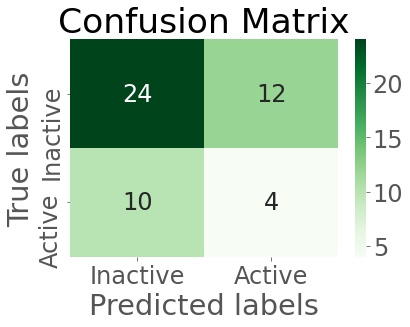

Calculating with fold 9
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 6s - loss: 3.1983 - accuracy: 0.5844 - precision_19: 0.2846 - recall_19: 0.2612 - val_loss: 2.8369 - val_accuracy: 0.3000 - val_precision_19: 0.3000 - val_recall_19: 1.0000
Epoch 2/10
450/450 - 1s - loss: 2.6729 - accuracy: 0.4956 - precision_19: 0.3038 - recall_19: 0.5373 - val_loss: 2.4059 - val_accuracy: 0.3000 - val_precision_19: 0.3000 - val_recall_19: 1.0000
Epoch 3/10
450/450 - 1s - loss: 2.3013 - accuracy: 0.5111 - precision_19: 0.2952 - recall_19: 0.4627 - val_loss: 2.1091 - val_accuracy: 0.3200 - val_precision_19: 0.3061 - val_recall_19: 1.0000
Epoch 4/10
450/450 - 1s - loss: 2.0313 - accuracy: 0.4333 - precision_19: 0.2816 - recall_19: 0.5821 - val_loss: 1.8984 - val_accuracy: 0.3000 - val_precision_19: 0.3000 - val_recall_19: 1.0000
Epoch 5/10
450/450 - 1s - loss: 1.8342 - accuracy: 0.4578 - precision_19: 0.2868 - recall_19: 0.5522 - val_loss: 1.7305 - val_accuracy: 0.3000 - val_precis

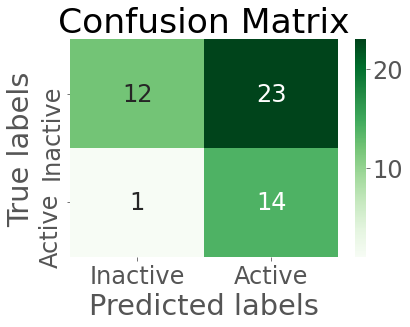

---> Test set fold 9
NER: 0.542, Sensitivity or recall: 1.000, Specificity: 0.083, Precision: 0.298, Correctly calssified: 0.340, MCC: 0.158


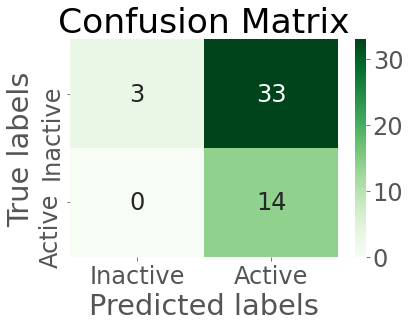

Best model was obtained from fold 1 with MCC 0.35043832202523123


NameError: name 'features' is not defined

In [58]:
layers_dim = [train_data.shape[1], 70,70,70, 1]
lr = 0.01
dropout = 0.5
optimizer = 'Adam'
L2 = 0.01
np.random.seed(1)

MCCs_train, MCCs_val, MCCs_test, accs_train, accs_val, accs_test, actives_train, actives_val, actives_test, best_model = run_cross_validation(layers_dim, lr, dropout, optimizer, L2, train_val_data, train_val_labels, mini_testing_2c9_data, mini_labels_testing_2c9_data, folds=10)

### 7.2.) Tunning Hyperparameters


In [51]:
hyperparam_tunning = False

HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(3, 10))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete([i for i in range(10,151,20)]))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))
N_BITS = train_data.shape[1]
    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=['accuracy'])
    model.fit(train_data, train_labels, epochs=10, verbose=2, class_weight=class_weight)
    _, results = model.evaluate(val_data, val_labels, verbose=0)                                                                                                
    _, results_val = model.evaluate(mini_testing_2c9_data, mini_labels_testing_2c9_data, verbose=0)
    return results, results_val 


def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy, accuracy_val = train_test_model(hparams)
    tf.summary.scalar("accuracy", accuracy, step=1)
    tf.summary.scalar("accuracy_val", accuracy_val, step=1)

In [ ]:
os.makedirs("hyperparameters_tunning/morgan_mordred_norm_6060_feature_selection", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/morgan_mordred_norm_6060_feature_selection').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy'), hp.Metric("accuracy_val", display_name="Validation_accuracy")]) 

In [ ]:
%tensorboard --logdir hyperparameters_tunning/morgan_mordred_norm_6060_feature_selection/logs/hparam_tuning/

In [52]:
if hyperparam_tunning:
    session_num = 0
    looping = list(product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values,[HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values))
    random.shuffle(looping)
    #looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
    total_runs = len(list(looping))
    for neurons, hidden_lay, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/morgan_mordred_norm_6060_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

---Starting trial: run_0 of 3360
{'neurons': 70, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.1}
Train on 375 samples
Epoch 1/10
375/375 - 6s - loss: 1.1052 - accuracy: 0.3333
Epoch 2/10
375/375 - 0s - loss: 1.0923 - accuracy: 0.4907
Epoch 3/10
375/375 - 0s - loss: 1.0697 - accuracy: 0.5840
Epoch 4/10
375/375 - 0s - loss: 1.0697 - accuracy: 0.6320
Epoch 5/10
375/375 - 0s - loss: 1.0217 - accuracy: 0.6427
Epoch 6/10
375/375 - 0s - loss: 1.0245 - accuracy: 0.6613
Epoch 7/10
375/375 - 0s - loss: 1.0602 - accuracy: 0.6667
Epoch 8/10
375/375 - 0s - loss: 0.9774 - accuracy: 0.6960
Epoch 9/10
375/375 - 0s - loss: 1.0040 - accuracy: 0.6827
Epoch 10/10
375/375 - 0s - loss: 1.0096 - accuracy: 0.6933
---Starting trial: run_1 of 3360
{'neurons': 10, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Train on 375 samples
Epoch 1/10
375/375 - 5s - loss: 16446487.3700 - accuracy: 0.5307
Epoc

KeyboardInterrupt: 